<a href="https://colab.research.google.com/github/FernandaSzAdr/KNN_cromossome/blob/master/TesteRede2_Binaria_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [143]:
import os
import cv2
import csv
!pip install imutils
import imutils
from skimage import transform
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import itertools
import matplotlib.pyplot as plt

## Funções

In [0]:
train_path = 'drive/My Drive/Base_CNN/Binarizado2/Train'
test_path = 'drive/My Drive/Base_CNN/Binarizado2/Test'
validation_path = 'drive/My Drive/Base_CNN/Binarizado2/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Base_CNN/Binarizado2/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            # Se é um cromossomo:
            if predicao[0][0] > predicao[0][1]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict




---



# Implementação



*   Batch size = 32
*   Image size = 120x120



## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [150]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 5675 images belonging to 2 classes.
Found 1509 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [152]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa Precision: 19.64%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [157]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 0.7587 - acc: 0.5990 - val_loss: 0.6538 - val_acc: 0.6406

Epoch 00001: val_loss improved from inf to 0.65376, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 2/50
 - 1s - loss: 0.6371 - acc: 0.6771 - val_loss: 0.7317 - val_acc: 0.5625

Epoch 00002: val_loss did not improve from 0.65376
Epoch 3/50
 - 1s - loss: 0.6716 - acc: 0.6354 - val_loss: 0.6512 - val_acc: 0.6719

Epoch 00003: val_loss improved from 0.65376 to 0.65120, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 4/50
 - 1s - loss: 0.6867 - acc: 0.5260 - val_loss: 0.6211 - val_acc: 0.6875

Epoch 00004: val_loss improved from 0.65120 to 0.62111, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 5/50
 - 1s - loss: 0.6590 - acc: 0.6354 - val_loss: 0.6776 - val_acc: 0.5938

Epoch 00005: val_loss did not improve from 0.62111
Epoch 6/50
 - 1s - loss: 0.6751 - acc: 0.6406 - val_loss: 0.6489 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

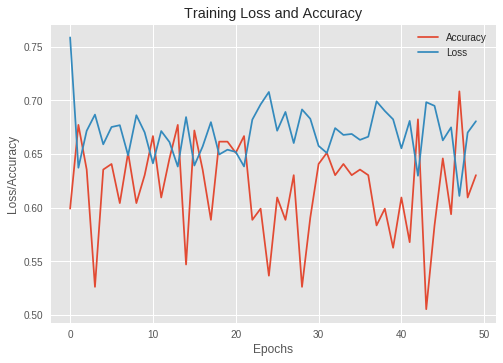

In [159]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [160]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [161]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.64%


## 2 tentativa  Precision: 19.64%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [166]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 0.6924 - acc: 0.5573 - val_loss: 0.6871 - val_acc: 0.7188

Epoch 00001: val_loss improved from inf to 0.68712, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6890 - acc: 0.6250 - val_loss: 0.6872 - val_acc: 0.6250

Epoch 00002: val_loss did not improve from 0.68712
Epoch 3/50
 - 1s - loss: 0.6844 - acc: 0.6458 - val_loss: 0.6799 - val_acc: 0.6875

Epoch 00003: val_loss improved from 0.68712 to 0.67995, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6794 - acc: 0.6615 - val_loss: 0.6802 - val_acc: 0.6406

Epoch 00004: val_loss did not improve from 0.67995
Epoch 5/50
 - 1s - loss: 0.6782 - acc: 0.6354 - val_loss: 0.6896 - val_acc: 0.5469

Epoch 00005: val_loss did not improve from 0.67995
Epoch 6/50
 - 1s - loss: 0.6784 - acc: 0.6198 - val_loss: 0.6802 - val_acc: 0.6094

Epoch 00006: val_loss did not improve from 0.67995
Epoch 7/50
 - 1s - loss:

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

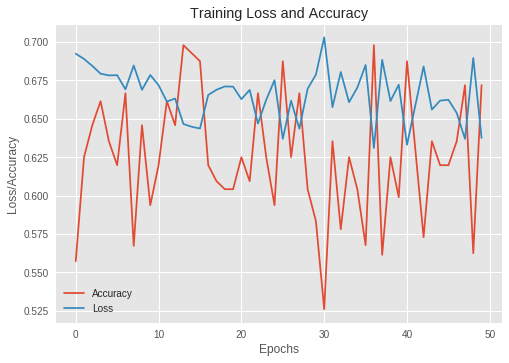

In [168]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [169]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [170]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.64%


## 3 tentativa Precision: 19.50%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [175]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 2.1012 - acc: 0.5000 - val_loss: 0.6046 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 0.60459, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 1.3763 - acc: 0.5625 - val_loss: 0.7083 - val_acc: 0.5703

Epoch 00002: val_loss did not improve from 0.60459
Epoch 3/50
 - 1s - loss: 0.8030 - acc: 0.6797 - val_loss: 0.4730 - val_acc: 0.8281

Epoch 00003: val_loss improved from 0.60459 to 0.47301, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 4/50
 - 1s - loss: 0.7298 - acc: 0.7109 - val_loss: 0.9080 - val_acc: 0.5391

Epoch 00004: val_loss did not improve from 0.47301
Epoch 5/50
 - 1s - loss: 0.6199 - acc: 0.7318 - val_loss: 0.6619 - val_acc: 0.6406

Epoch 00005: val_loss did not improve from 0.47301
Epoch 6/50
 - 1s - loss: 0.5448 - acc: 0.7734 - val_loss: 0.7161 - val_acc: 0.6484

Epoch 00006: val_loss did not improve from 0.47301
Epoch 7/50
 - 1s - loss:

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

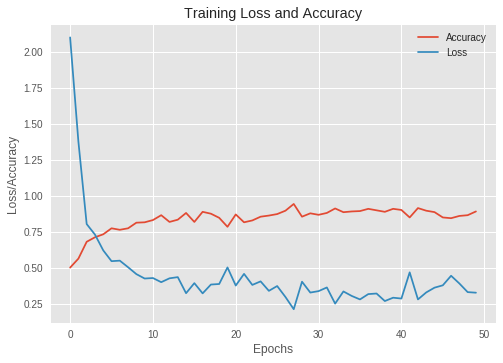

In [177]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [178]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [179]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.50%


## 4 tentativa Precision: 19.64%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [184]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 0.5196 - acc: 0.7865 - val_loss: 1.4706 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 1.47065, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 2/50
 - 1s - loss: 0.4075 - acc: 0.8594 - val_loss: 1.5410 - val_acc: 0.5946

Epoch 00002: val_loss did not improve from 1.47065
Epoch 3/50
 - 1s - loss: 0.3526 - acc: 0.8724 - val_loss: 1.0795 - val_acc: 0.5312

Epoch 00003: val_loss improved from 1.47065 to 1.07948, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 4/50
 - 1s - loss: 0.2851 - acc: 0.9245 - val_loss: 0.4492 - val_acc: 0.8594

Epoch 00004: val_loss improved from 1.07948 to 0.44916, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 5/50
 - 1s - loss: 0.4031 - acc: 0.8906 - val_loss: 0.4779 - val_acc: 0.8047

Epoch 00005: val_loss did not improve from 0.44916
Epoch 6/50
 - 1s - loss: 0.2927 - acc: 0.9375 - val_loss: 0.3694 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

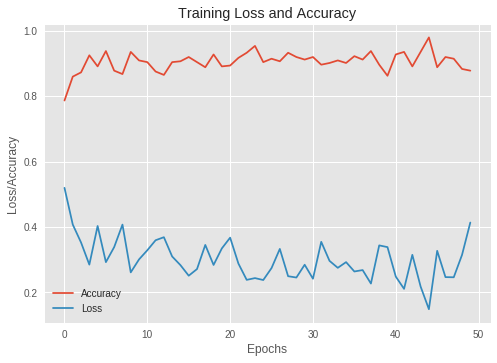

In [186]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [187]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [188]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.64%


## 5 tentativa Precision: 19.66%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [193]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 3.4989 - acc: 0.5339 - val_loss: 1.5055 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 1.50550, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 2/50
 - 1s - loss: 1.8813 - acc: 0.5599 - val_loss: 0.7845 - val_acc: 0.6016

Epoch 00002: val_loss improved from 1.50550 to 0.78448, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 3/50
 - 1s - loss: 1.2079 - acc: 0.6094 - val_loss: 0.6431 - val_acc: 0.6406

Epoch 00003: val_loss improved from 0.78448 to 0.64305, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 4/50
 - 1s - loss: 0.7594 - acc: 0.7158 - val_loss: 1.0169 - val_acc: 0.4531

Epoch 00004: val_loss did not improve from 0.64305
Epoch 5/50
 - 1s - loss: 0.7479 - acc: 0.6823 - val_loss: 0.6100 - val_acc: 0.5859

Epoch 00005: val_loss improved from 0.64305 to 0.61005, saving model to drive/My Drive/Resultado/Segmentado/weights_architect

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

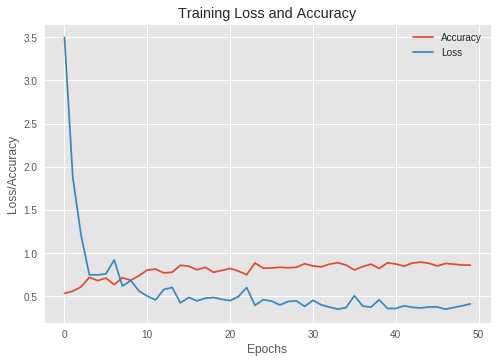

In [195]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [196]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [197]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.66%


## 6 tentativa Precision: 19.64%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [202]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 0.5910 - acc: 0.7448 - val_loss: 1.0117 - val_acc: 0.5469

Epoch 00001: val_loss improved from inf to 1.01165, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 2/50
 - 1s - loss: 0.5499 - acc: 0.7344 - val_loss: 1.1698 - val_acc: 0.6172

Epoch 00002: val_loss did not improve from 1.01165
Epoch 3/50
 - 1s - loss: 0.4836 - acc: 0.8021 - val_loss: 0.6376 - val_acc: 0.6562

Epoch 00003: val_loss improved from 1.01165 to 0.63758, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 4/50
 - 1s - loss: 0.4357 - acc: 0.8672 - val_loss: 0.5831 - val_acc: 0.6953

Epoch 00004: val_loss improved from 0.63758 to 0.58315, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 5/50
 - 1s - loss: 0.4346 - acc: 0.8464 - val_loss: 0.5233 - val_acc: 0.8125

Epoch 00005: val_loss improved from 0.58315 to 0.52327, saving model to drive/My Drive/Resultado/Segmentado/weights_architect

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

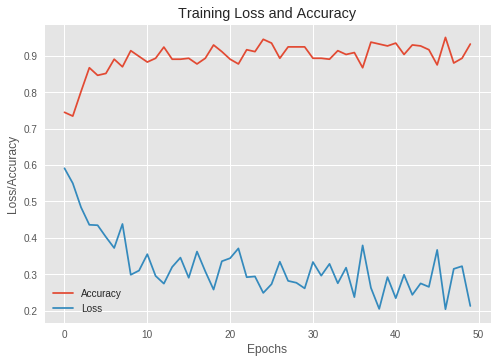

In [204]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [205]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [206]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.64%


## 7 tentativa Precision: 19.64%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [211]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 8s - loss: 0.6326 - acc: 0.7109 - val_loss: 0.9091 - val_acc: 0.7031

Epoch 00001: val_loss improved from inf to 0.90913, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 2/50
 - 1s - loss: 0.4593 - acc: 0.8385 - val_loss: 1.3066 - val_acc: 0.6172

Epoch 00002: val_loss did not improve from 0.90913
Epoch 3/50
 - 1s - loss: 0.3797 - acc: 0.8620 - val_loss: 0.9731 - val_acc: 0.6328

Epoch 00003: val_loss did not improve from 0.90913
Epoch 4/50
 - 1s - loss: 0.3590 - acc: 0.8958 - val_loss: 0.4167 - val_acc: 0.8125

Epoch 00004: val_loss improved from 0.90913 to 0.41667, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 5/50
 - 1s - loss: 0.4138 - acc: 0.8802 - val_loss: 1.1963 - val_acc: 0.5405

Epoch 00005: val_loss did not improve from 0.41667
Epoch 6/50
 - 1s - loss: 0.2759 - acc: 0.9193 - val_loss: 0.9726 - val_acc: 0.6641

Epoch 00006: val_loss did not improve from 0.41667
Epoch 7/50
 - 1s - loss:

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

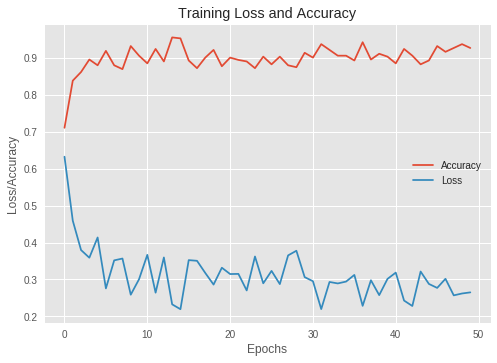

In [213]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [214]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [215]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.64%


## 8 tentativa Precision: 19.68%

Modelo adaptado do **Lucas Albertins**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [220]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 8s - loss: 2.1750 - acc: 0.5344 - val_loss: 0.6916 - val_acc: 0.6641

Epoch 00001: val_loss improved from inf to 0.69158, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 1.2558 - acc: 0.5859 - val_loss: 0.8050 - val_acc: 0.6172

Epoch 00002: val_loss did not improve from 0.69158
Epoch 3/50
 - 1s - loss: 0.9947 - acc: 0.6224 - val_loss: 0.5814 - val_acc: 0.6953

Epoch 00003: val_loss improved from 0.69158 to 0.58135, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 4/50
 - 1s - loss: 0.8660 - acc: 0.6302 - val_loss: 0.5669 - val_acc: 0.7422

Epoch 00004: val_loss improved from 0.58135 to 0.56692, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 5/50
 - 1s - loss: 0.7563 - acc: 0.7031 - val_loss: 0.5954 - val_acc: 0.7422

Epoch 00005: val_loss did not improve from 0.56692
Epoch 6/50
 - 1s - loss: 0.5556 - acc: 0.7370 - val_loss: 0.6312 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

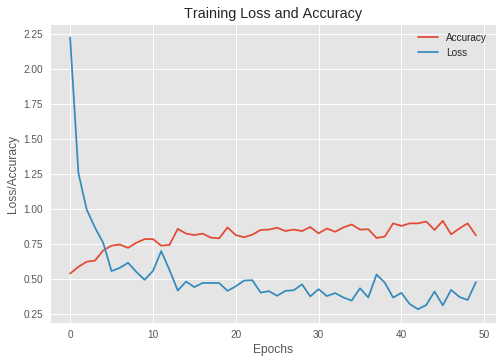

In [222]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [223]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [224]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.68%


## 9 tentativa Precision: 19.65%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [229]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 8s - loss: 5.8182 - acc: 0.5026 - val_loss: 5.5984 - val_acc: 0.4531

Epoch 00001: val_loss improved from inf to 5.59842, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 2/50
 - 1s - loss: 6.2543 - acc: 0.5026 - val_loss: 6.6733 - val_acc: 0.4453

Epoch 00002: val_loss did not improve from 5.59842
Epoch 3/50
 - 1s - loss: 3.2866 - acc: 0.5911 - val_loss: 1.0067 - val_acc: 0.5000

Epoch 00003: val_loss improved from 5.59842 to 1.00669, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 4/50
 - 1s - loss: 1.0623 - acc: 0.5833 - val_loss: 0.6859 - val_acc: 0.6094

Epoch 00004: val_loss improved from 1.00669 to 0.68587, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 5/50
 - 1s - loss: 0.8248 - acc: 0.5417 - val_loss: 0.6514 - val_acc: 0.6797

Epoch 00005: val_loss improved from 0.68587 to 0.65138, saving model to drive/My Drive/Resultado/Segmentado/weights_architect

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

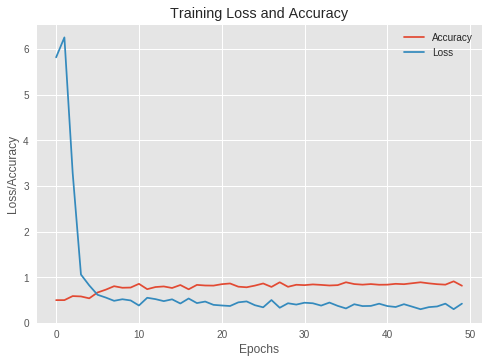

In [231]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [232]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [233]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.65%


## 10 tentativa Precision: 19.64%

Modelo adaptado do **Lucas Albertins**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [238]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 9s - loss: 1.6225 - acc: 0.5417 - val_loss: 0.7600 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.76003, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 1.1344 - acc: 0.6380 - val_loss: 0.5734 - val_acc: 0.7422

Epoch 00002: val_loss improved from 0.76003 to 0.57343, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 3/50
 - 1s - loss: 0.8573 - acc: 0.6380 - val_loss: 0.8993 - val_acc: 0.5078

Epoch 00003: val_loss did not improve from 0.57343
Epoch 4/50
 - 1s - loss: 0.7105 - acc: 0.6641 - val_loss: 0.6354 - val_acc: 0.6875

Epoch 00004: val_loss did not improve from 0.57343
Epoch 5/50
 - 1s - loss: 0.6801 - acc: 0.7135 - val_loss: 0.5237 - val_acc: 0.8203

Epoch 00005: val_loss improved from 0.57343 to 0.52366, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 6/50
 - 1s - loss: 0.6309 - acc: 0.7578 - val_loss: 0.3606 - val_

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

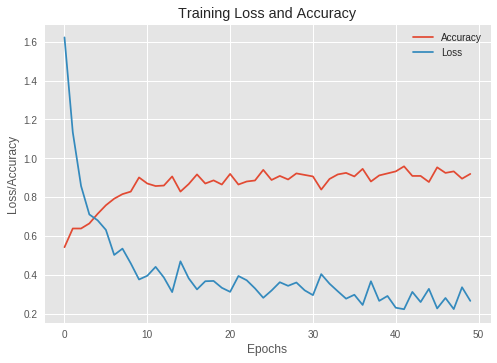

In [240]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [241]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [242]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.64%


## 11 tentativa recision: 19.65%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [247]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 9s - loss: 2.1092 - acc: 0.5312 - val_loss: 1.1008 - val_acc: 0.5270

Epoch 00001: val_loss improved from inf to 1.10076, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 1.8341 - acc: 0.5391 - val_loss: 0.8953 - val_acc: 0.5234

Epoch 00002: val_loss improved from 1.10076 to 0.89526, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 1.3053 - acc: 0.5599 - val_loss: 0.6777 - val_acc: 0.6562

Epoch 00003: val_loss improved from 0.89526 to 0.67774, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 4/50
 - 1s - loss: 1.0581 - acc: 0.5547 - val_loss: 0.6224 - val_acc: 0.6797

Epoch 00004: val_loss improved from 0.67774 to 0.62236, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 5/50
 - 1s - loss: 0.8375 - acc: 0.6589 - val_loss: 0.7411 - val_acc: 0.5547

Epoch 00005: val_loss did not improv

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

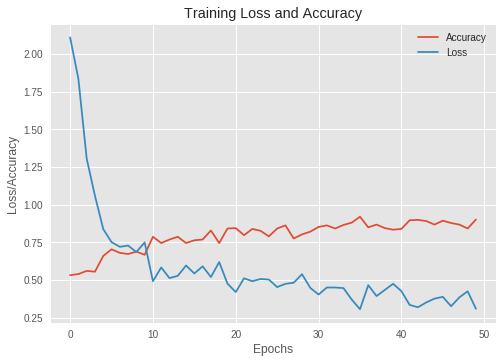

In [249]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [250]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [251]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.65%


## 12 tentativa Precision: 19.64%

Modelo adaptado do **Lucas Albertins**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [256]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 9s - loss: 1.7031 - acc: 0.5000 - val_loss: 0.7088 - val_acc: 0.6172

Epoch 00001: val_loss improved from inf to 0.70882, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 1.3478 - acc: 0.5729 - val_loss: 0.7013 - val_acc: 0.5156

Epoch 00002: val_loss improved from 0.70882 to 0.70134, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 1.0541 - acc: 0.5625 - val_loss: 0.5993 - val_acc: 0.6562

Epoch 00003: val_loss improved from 0.70134 to 0.59929, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 0.9551 - acc: 0.6432 - val_loss: 0.6516 - val_acc: 0.5625

Epoch 00004: val_loss did not improve from 0.59929
Epoch 5/50
 - 1s - loss: 0.9130 - acc: 0.5911 - val_loss: 0.5716 - val_acc: 0.7344

Epoch 00005: val_loss improved from 0.59929 to 0.57164, saving model to drive/My Drive/Resultado/Segmentado/weights_archit

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

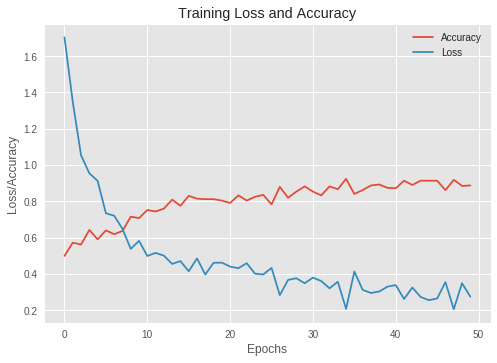

In [258]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [259]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [260]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.64%


## 13 tentativa Precision: 19.64%

Modelo adaptado do **Lucas Albertins**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [265]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 10s - loss: 1.1454 - acc: 0.5807 - val_loss: 0.5419 - val_acc: 0.7266

Epoch 00001: val_loss improved from inf to 0.54189, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.7736 - acc: 0.6615 - val_loss: 0.5672 - val_acc: 0.6562

Epoch 00002: val_loss did not improve from 0.54189
Epoch 3/50
 - 0s - loss: 0.6865 - acc: 0.6693 - val_loss: 0.4630 - val_acc: 0.7734

Epoch 00003: val_loss improved from 0.54189 to 0.46297, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 4/50
 - 0s - loss: 0.5893 - acc: 0.7266 - val_loss: 0.4784 - val_acc: 0.7031

Epoch 00004: val_loss did not improve from 0.46297
Epoch 5/50
 - 1s - loss: 0.5017 - acc: 0.7526 - val_loss: 0.4501 - val_acc: 0.7734

Epoch 00005: val_loss improved from 0.46297 to 0.45013, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 6/50
 - 1s - loss: 0.5857 - acc: 0.7005 - val_loss: 0.3499 - val

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

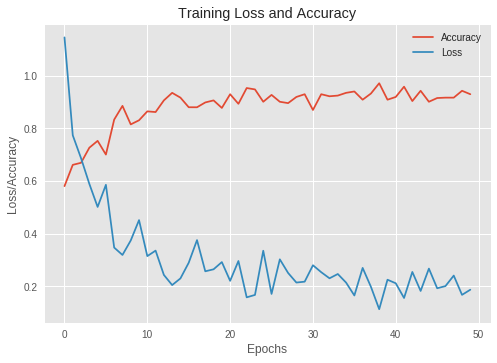

In [267]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/' + architecture + '.png', bbox_inches='tight')

### Teste

In [268]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [269]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 19.64%
